# Correlation analysis and visualization

There are 4 parts in this file.  
1. Calculate p-value, adjusted p-value, correlation R with clean data.
2. Overview of calculated result in volcano plot.
3. Analyze results for the key findings.
4. Use 'Colorectal' as an example to visualize key findings

In [1]:
# Load packages and data, set global options, and define funtion.
library(tidyverse)
library(magrittr)
library(tools)


options(warn = -1)
options(repr.plot.width=12, repr.plot.height=9)
load(file = 'data/clean/incidence_rf.Rdata')
load(file = 'data/clean/mortality_rf.Rdata')

get_pvalue <- function(measure,df,value) {
  anova_model <- aov(as.formula(paste0(measure, "~","`",value,"`")), data=df)
  anova_summary <- summary(anova_model)
  p_value <- anova_summary[[1]][paste0("`",value,"`"), "Pr(>F)"]
  return(p_value)
}

get_pvalue_df <- function(df,cancer,rate='incidence_rate'){
  p_values_for_feature <- data.frame(p_value=numeric(),p_adjusted=numeric(),comparisons=integer(),
                         cancer=character(),feature=character())
  for(value in names(df)[4:length(df)]){
    p_value <- get_pvalue(rate,df,value)
    p_values_for_feature %<>% rbind(setNames(c(p_value,NA,NA,cancer,value) %>% as.list(),names(p_values_for_feature)))
  }
  p_values_for_feature$comparisons <- nrow(p_values_for_feature)
  p_values_for_feature$p_adjusted <- p.adjust(p_values_for_feature$p_value)
  return(p_values_for_feature)
}

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract




In [2]:
# Calculate p-values of features of particular `cancer` in `df`. 
# It will return a new dataframe, whose columns are p_value, p_adjusetd, comparisons, cancer, feature.

# Calculate p-values for incidence and mortality
p_values_incidence <- data.frame(p_value=numeric(),p_adjusted=numeric(),comparisons=integer(),
                          cancer=character(),feature=character())
for(cancer in names(incidence_rf)){
  for(feature in names(incidence_rf[[cancer]][[1]])){
    p_values_for_feature <- get_pvalue_df(incidence_rf[[cancer]][[1]][[feature]],cancer)
    p_values_incidence %<>% rbind(p_values_for_feature)
  }
}


p_values_mortality <- data.frame(p_value=numeric(),p_adjusted=numeric(),comparisons=integer(),
                                 cancer=character(),feature=character())
for(cancer in names(mortality_rf)){
  for(feature in names(mortality_rf[[cancer]][[1]])){
    p_values_for_feature <- get_pvalue_df(mortality_rf[[cancer]][[1]][[feature]]
                                          ,cancer,rate = "mortality_rate ")
    p_values_mortality %<>% rbind(p_values_for_feature)
  }
}

p_values_incidence$p_value %<>% as.numeric()
p_values_mortality$p_value %<>% as.numeric()

# This part is used to count total number comparisons for each cancer, and calculate adjusted p-values. 
# Given different types of features are independent of each other, this portion of the data is provided for reference.
cor_incidence <- data.frame(p_pearson=numeric(),cor=numeric(),cancer=character(),
                            feature=character(),comparisons_across_feature=integer())
for(cancer in names(incidence_rf)){
  comparisons_across_feature <- 0
  for(feature in names(incidence_rf[[cancer]][[1]])){
    temp <- incidence_rf[[cancer]][[1]][[feature]]
    # Only use number of children in female cancer
    if(names(incidence_rf[[cancer]]) %in% c('Male','AllSex') & feature == "children") {
      next
    }
    for(value in names(temp)[5:length(temp)]){
      cor <- cor.test(temp[[value]],temp[['incidence_rate']])$estimate  
      p_pearson <- cor.test(temp[[value]],temp[['incidence_rate']])$p.value
      cor_incidence %<>% rbind(setNames(c(p_pearson,cor,cancer,value,-1) %>% as.list(),names(cor_incidence)))
      comparisons_across_feature <- comparisons_across_feature + 1
      }
  }
  cor_incidence$comparisons_across_feature[cor_incidence$cancer == cancer] <- comparisons_across_feature
}
cor_incidence %<>% left_join(p_values_incidence, by = c('cancer','feature'))


cor_mortality <-data.frame(p_pearson=numeric(),cor=numeric(),cancer=character(),
                           feature=character(),comparisons_across_feature=integer())
for(cancer in names(mortality_rf)){
  comparisons_across_feature <- 0
  for(feature in names(mortality_rf[[cancer]][[1]])){
    temp <- mortality_rf[[cancer]][[1]][[feature]]
    # Only use number of children in female cancer
    if(names(mortality_rf[[cancer]]) %in% c('Male','AllSex') & feature == "children") {
      next
    }
    for(value in names(temp)[5:length(temp)]){
      cor <- cor.test(temp[[value]],temp[['mortality_rate']])$estimate  
      p_pearson <- cor.test(temp[[value]],temp[['mortality_rate']])$p.value
      cor_mortality %<>% rbind(setNames(c(p_pearson,cor,cancer,value,-1) %>% as.list(),names(cor_mortality)))
      comparisons_across_feature <- comparisons_across_feature + 1 
      }
  }
  cor_mortality$comparisons_across_feature[cor_mortality$cancer == cancer] <- comparisons_across_feature
}
cor_mortality %<>% left_join(p_values_mortality, by = c('cancer','feature'))

cor_incidence$cor %<>% as.numeric()
cor_mortality$cor %<>% as.numeric()

for (cancer in cor_mortality$cancer %>% unique()) {
  cor_mortality$p_adjusted_all_features[cor_mortality$cancer == cancer] <- p.adjust(
    cor_mortality$p_value[cor_mortality$cancer == cancer] )
}
for (cancer in cor_incidence$cancer %>% unique()) {
  cor_incidence$p_adjusted_all_features[cor_incidence$cancer == cancer] <- p.adjust(
    cor_incidence$p_value[cor_incidence$cancer == cancer] )
}


write.csv(cor_mortality,'data/correlation_result/cor_mortality.csv',row.names=F)
write.csv(cor_incidence,'data/correlation_result/cor_incidence.csv',row.names=F)

cor_mortality %>% head(3)
cor_incidence %>% head(3)

,p_pearson,cor,cancer,feature,comparisons_across_feature,p_value,p_adjusted,comparisons,p_adjusted_all_features
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,0.0600940107917012,-0.14120761,Brain,Water-censoredValue_max_Dissolved Reactive Phosphorus,162,0.06009401,0.6009401,10,1
2,0.482778371474275,0.05309254,Brain,Water-censoredValue_max_E. Coli,162,0.48277837,1.0000000,10,1
3,0.58159491383323,0.03919629,Brain,Water-censoredValue_max_Electrical Conductivity,162,0.58159491,1.0000000,10,1


,p_pearson,cor,cancer,feature,comparisons_across_feature,p_value,p_adjusted,comparisons,p_adjusted_all_features
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,0.00030514139962242,-0.26758110,Bladder,Water-censoredValue_max_Dissolved Reactive Phosphorus,162,0.0003051414,0.003051414,10,0.04821234
2,0.37257747938119,0.06742235,Bladder,Water-censoredValue_max_E. Coli,162,0.3725774794,1.000000000,10,1.00000000
3,0.556068523325851,0.04187093,Bladder,Water-censoredValue_max_Electrical Conductivity,162,0.5560685233,1.000000000,10,1.00000000


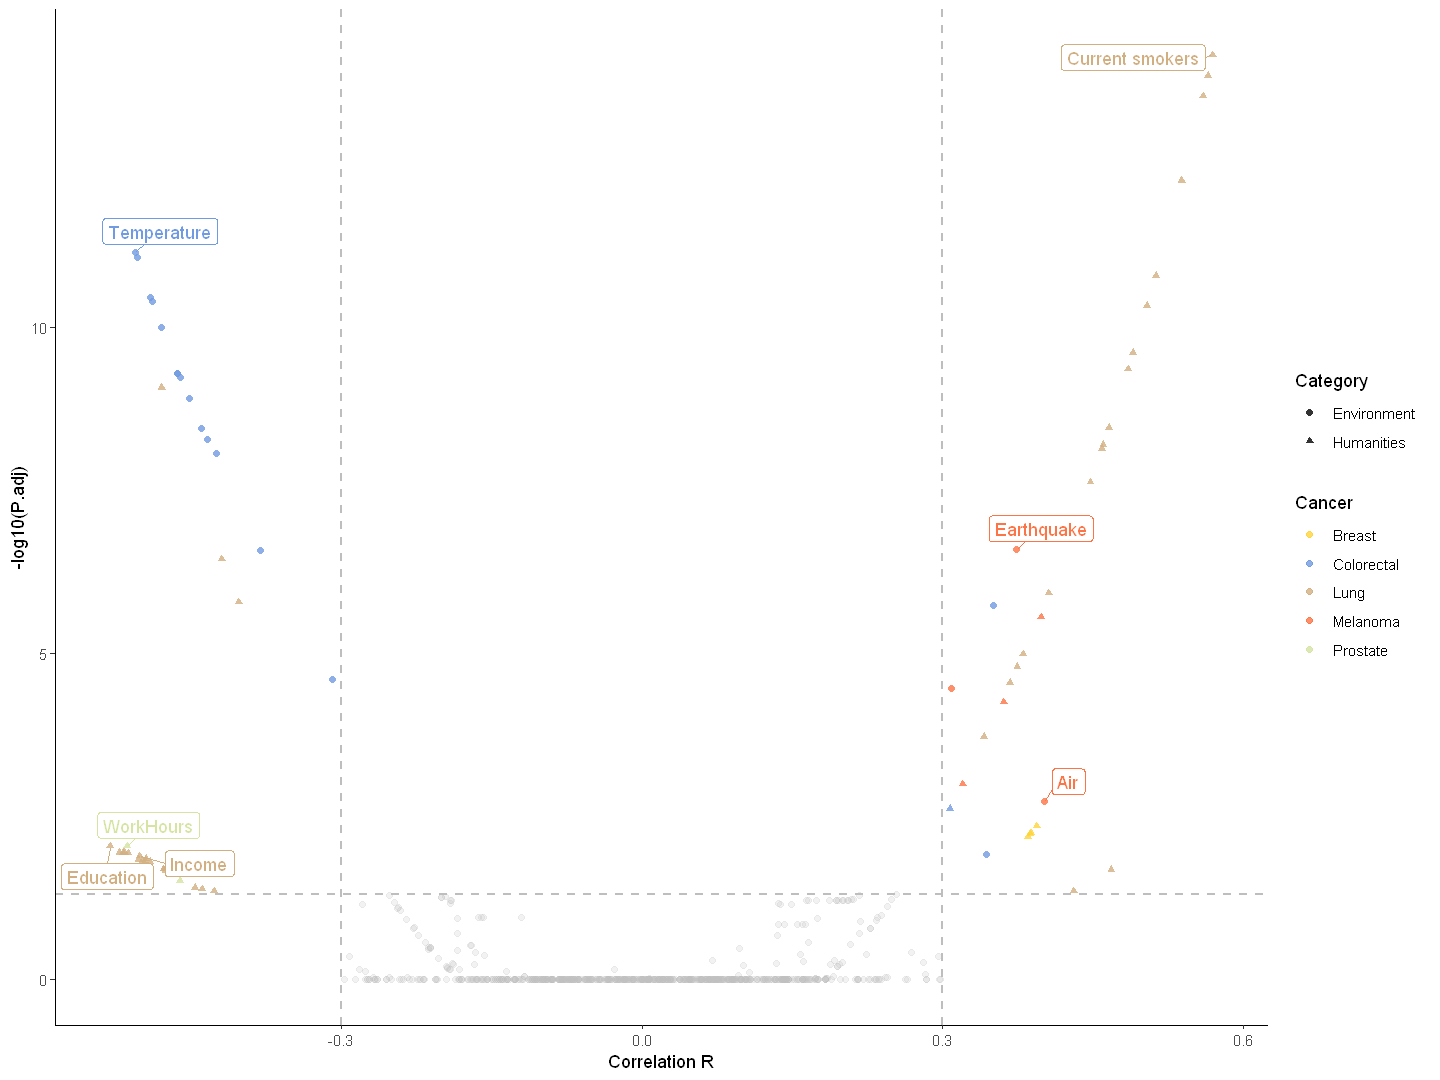

In [3]:
# We use top 5 cancers for visualization.

CAs = list(c("Prostate","Breast","Colorectal"),"Lung","Melanoma") #only view results of top 5 cancers

cor_incidence <- cor_incidence %>% 
  filter(cancer %in% c("Prostate","Breast","Colorectal","Lung","Melanoma")) %>%
  filter(!is.na(p_value)) %>%
  separate(feature,into=c("group",'var'),sep ='-',extra = 'merge',remove = FALSE) %>% #separate original variable, extract the group info and variable info
  mutate(sign = ifelse(cor > 0,"pos","neg"),
         category = case_when(group %in% c("Air","Earthquake","Water","Temperature") ~ "Environment",
                              TRUE ~ "Humanities"),
         group2 = case_when(group == "NZHS" ~ var,
                            TRUE ~ group)
  ) %>%
  rename(Cancer = cancer, Category = category) 

# filter significant result for ggplot point
sig.point <- cor_incidence %>%
  filter(p_adjusted < 0.05, abs(cor) >= 0.3) #significant results are defined as abs(r) >= 0.3 and p.adj < 0.05

# filter non-significant result for ggplot point
non.sig.point <- cor_incidence %>%
  filter(p_adjusted >= 0.05, abs(cor) < 0.3) #significant results are defined as asb(r) < 0.3 and p.adj >= 0.05#

cols = ggsci::pal_simpsons("springfield")(16)
cols = cols[-3] # remove grey color


#filter most relevant RFs for labels in ggplot
labels <- sig.point %>%
  group_by(group) %>%
  top_n(1,abs(cor))

#draw volcano plot
cor_incidence %>% 
  ggplot(aes(x=cor , y=-log10(p_adjusted))) +
  geom_vline(xintercept = c(-0.3, 0.3), linetype = "dashed", color = "grey",size=0.8) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "grey",size=0.8)+
  geom_point(sig.point, mapping = aes(x=cor , y=-log10(p_adjusted),color = Cancer,shape = Category), size=1.5, alpha=0.8) + 
  scale_color_manual(values = cols)+
  geom_point(non.sig.point,mapping = aes(x=cor , y=-log10(p_adjusted)),color = 'grey', size=1.5, alpha=0.2) + 
  ggrepel::geom_label_repel(labels,mapping = aes(x=cor , y=-log10(p_adjusted),color = Cancer,label = group2),
                            show.legend = F,
                            min.segment.length = 0,
                            force_pull = 1.5)+
  labs(y = "-log10(P.adj)", x = "Correlation R")+
  theme_classic() 




In [4]:

#result visualized with tables for corresponding cancer types
#Less risk factors for c("Prostate","Breast","Colorectal"), shown in a single table for these three cancers

sig.tables <- list()

for(i in 1:length(CAs)){
  ca = CAs[[i]]
  
  #set filters of variables
  #some variables are similar, such as 'Healthy weight','Mean weight (kg)', 'Overweight or obese', these are all related to the same RF (overweight), and thus filtered for better demontration
  var_filters=c()
  if( "Lung" %in% ca){
      var_filters = c("Obese class 1","Obese class 2","Obese class 3",
                      'Overweight or obese',
                      'Teeth removed due to decay in past 12 months',
                      'Waist to height ratio ≥ 0.5',
                      'Mean weight (kg)',
                      'Mean waist (cm)',
                      'All teeth removed due to decay',
                      'Healthy weight',
                      'Daily smokers'
                      )
  }else if("Breast" %in% ca){
    var_filters = c('Heavy episodic drinking at least monthly (past-year drinkers)',
                    "Heavy episodic drinking at least monthly (total population)",
                    "Heavy episodic drinking at least weekly (past-year drinkers)")
  }
  
  sig.point %>%
    filter(!var %in% var_filters) %>% #filter similar variables
    # filter(abs(cor) > 0.3) %>% # show correlation RF with r > 0.3
    filter(!(group == "Temperature" & var != "Average_Annual")) %>% # for temperature variables, only show the annual average
    filter(Cancer %in% ca ) %>% # filter by cancer types
    group_by(Category,group2,Cancer) %>% 
    top_n(1,abs(cor))%>% #filter the most relevant RFs based on group2 for each cancer type
    ungroup(.)%>%
    mutate(
      # sign = ifelse(cor > 0,"pos","neg"), #correlation direction, positive or negative
      # category = case_when(group %in% c("Air","Earthquake","Water","Temperature") ~ "Environment", # set two category, Environment and Humanities
      #                      TRUE ~ "Humanities"),
      # group2 = case_when(group == "NZHS" ~ var, #NZHS has many different group, here show NZHS based on the variable as group
      #                    TRUE ~ group),
      Correlation = case_when(sign == "pos" ~ '+',sign == "neg" ~ "-"),
      var = toTitleCase(str_replace_all(var,'_'," ")), #capitalize first character of each word in variabel
      var = str_replace_all(var,'(?<=\\().+?(?=\\))',tolower), #words within () remains lower format
    ) %>%
    select(Cancer,Correlation,Category,group,var,cor,p_adjusted,feature) %>%
    #modify###########
    arrange(factor(Cancer,levels = c("Lung","Melanoma","Breast","Prostate","Colorectal")),Correlation) %>%
    rename(r = cor, p.adj = p_adjusted, `Risk Factors` = var, Group = group) -> sig.tables[[i]]
  
  sig.tables[[i]] %>%
    select(-feature) %>%
    rempsyc::nice_table(short = F,title = paste0( "Table",i+1,". Risk factors of ", paste(ca,collapse = ', '))) %>%
    flextable::line_spacing(space = 0.8)-> tab #Here table index starts from 2 and thus use i+1
    # flextable::theme_vanilla() %>%
    # flextable::merge_v(j = c("Cancer", "Category","Group"))-> tab
  print(tab)
  cat('\n\n\n')
}


a flextable object.
col_keys: `Cancer`, `Correlation`, `Category`, `Group`, `Risk Factors`, `r`, `p.adj` 
header has 2 row(s) 
body has 5 row(s) 
original dataset sample: 
      Cancer Correlation    Category      Group
1     Breast           +  Humanities       NZHS
2   Prostate           -  Humanities  WorkHours
3 Colorectal           + Environment        Air
4 Colorectal           + Environment Earthquake
5 Colorectal           +  Humanities       NZHS
                                                Risk Factors          r
1 Heavy Episodic Drinking at Least Weekly (total population)  0.3878799
2                                                 ≥ 10 Hours -0.5133667
3                                    Concentration Max PM2.5  0.3438462
4                                             Magnitude Mean  0.3501052
5                                         Past-Year Drinkers  0.3071665
         p.adj
1 5.813922e-03
2 9.162889e-03
3 1.241351e-02
4 1.867782e-06
5 2.409660e-03



a flextable obj

#### The output cannot be formmated correctly in Jupyter. The output should be as following tables.


<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8" />
<style>body{background-color:white;}</style>
<style type="text/css">.tabwid {
font-size: initial;
padding-bottom: 1em;
}
.tabwid table{
border-spacing:0px !important;
border-collapse:collapse;
line-height:1;
margin-left:auto;
margin-right:auto;
border-width: 0;
border-color: transparent;
caption-side: top;
}
.tabwid-caption-bottom table{
caption-side: bottom;
}
.tabwid_left table{
margin-left:0;
}
.tabwid_right table{
margin-right:0;
}
.tabwid td, .tabwid th {
padding: 0;
}
.tabwid a {
text-decoration: none;
}
.tabwid thead {
background-color: transparent;
}
.tabwid tfoot {
background-color: transparent;
}
.tabwid table tr {
background-color: transparent;
}
.katex-display {
margin: 0 0 !important;
}
</style>
<script>document.addEventListener("DOMContentLoaded", function(event) {
  var els = document.querySelectorAll(".tabwid");
  var tabwid_link = document.querySelector('link[href*="tabwid.css"]')
  if (tabwid_link === null) {
    const tabwid_styles = document.evaluate("//style[contains(., 'tabwid')]", document, null, XPathResult.ANY_TYPE, null );
    tabwid_link = tabwid_styles.iterateNext();
  }

  Array.prototype.forEach.call(els, function(template) {
      const dest = document.createElement("div");
      template.parentNode.insertBefore(dest, template.nextSibling)
      dest.setAttribute("class", "flextable-shadow-host");
      const fantome = dest.attachShadow({mode: 'open'});
      fantome.appendChild(template);
      if (tabwid_link !== null) {
        fantome.appendChild(tabwid_link.cloneNode(true));
      }
  });
});

</script>

</head>
<body>
<style></style>
<div class="tabwid"><style>.cl-1f31744a{table-layout:auto;}.cl-1f2320ac{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:italic;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-1f2320d4{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:normal;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-1f2930dc{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-1f2930e6{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-1f2930f0{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-1f2930f1{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-1f296dcc{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(102, 102, 102, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f296dd6{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0.5pt solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f296de0{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f296de1{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f296dea{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f296df4{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}</style><table data-quarto-disable-processing="true" class="cl-1f31744a"><thead><tr style="overflow-wrap:break-word;"><th colspan="7" class="cl-1f296dcc"><p class="cl-1f2930dc"><span class="cl-1f2320ac">Table2. Risk factors of Prostate, Breast, Colorectal</span></p></th></tr><tr style="overflow-wrap:break-word;"><th class="cl-1f296dd6"><p class="cl-1f2930e6"><span class="cl-1f2320d4">Cancer</span></p></th><th class="cl-1f296dd6"><p class="cl-1f2930e6"><span class="cl-1f2320d4">Correlation</span></p></th><th class="cl-1f296dd6"><p class="cl-1f2930e6"><span class="cl-1f2320d4">Category</span></p></th><th class="cl-1f296dd6"><p class="cl-1f2930e6"><span class="cl-1f2320d4">Group</span></p></th><th class="cl-1f296dd6"><p class="cl-1f2930e6"><span class="cl-1f2320d4">Risk Factors</span></p></th><th class="cl-1f296dd6"><p class="cl-1f2930e6"><span class="cl-1f2320ac">r</span></p></th><th class="cl-1f296dd6"><p class="cl-1f2930e6"><span class="cl-1f2320d4">p.adj</span></p></th></tr></thead><tbody><tr style="overflow-wrap:break-word;"><td class="cl-1f296de0"><p class="cl-1f2930f0"><span class="cl-1f2320d4">Breast</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">+</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Humanities</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">NZHS</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Heavy Episodic Drinking at Least Weekly (total population)</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">.39</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">0.01</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f296de0"><p class="cl-1f2930f0"><span class="cl-1f2320d4">Prostate</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">-</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Humanities</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">WorkHours</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">≥ 10 Hours</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">-.51</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">0.01</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f296de0"><p class="cl-1f2930f0"><span class="cl-1f2320d4">Colorectal</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">+</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Environment</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Air</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Concentration Max PM2.5</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">.34</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">0.01</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f296de0"><p class="cl-1f2930f0"><span class="cl-1f2320d4">Colorectal</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">+</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Environment</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Earthquake</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Magnitude Mean</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">.35</span></p></td><td class="cl-1f296de1"><p class="cl-1f2930f1"><span class="cl-1f2320d4">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f296dea"><p class="cl-1f2930f0"><span class="cl-1f2320d4">Colorectal</span></p></td><td class="cl-1f296df4"><p class="cl-1f2930f1"><span class="cl-1f2320d4">+</span></p></td><td class="cl-1f296df4"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Humanities</span></p></td><td class="cl-1f296df4"><p class="cl-1f2930f1"><span class="cl-1f2320d4">NZHS</span></p></td><td class="cl-1f296df4"><p class="cl-1f2930f1"><span class="cl-1f2320d4">Past-Year Drinkers</span></p></td><td class="cl-1f296df4"><p class="cl-1f2930f1"><span class="cl-1f2320d4">.31</span></p></td><td class="cl-1f296df4"><p class="cl-1f2930f1"><span class="cl-1f2320d4">0.00</span></p></td></tr></tbody></table></div>
</body>
</html>



<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8" />
<style>body{background-color:white;}</style>
<style type="text/css">.tabwid {
font-size: initial;
padding-bottom: 1em;
}
.tabwid table{
border-spacing:0px !important;
border-collapse:collapse;
line-height:1;
margin-left:auto;
margin-right:auto;
border-width: 0;
border-color: transparent;
caption-side: top;
}
.tabwid-caption-bottom table{
caption-side: bottom;
}
.tabwid_left table{
margin-left:0;
}
.tabwid_right table{
margin-right:0;
}
.tabwid td, .tabwid th {
padding: 0;
}
.tabwid a {
text-decoration: none;
}
.tabwid thead {
background-color: transparent;
}
.tabwid tfoot {
background-color: transparent;
}
.tabwid table tr {
background-color: transparent;
}
.katex-display {
margin: 0 0 !important;
}
</style>
<script>document.addEventListener("DOMContentLoaded", function(event) {
  var els = document.querySelectorAll(".tabwid");
  var tabwid_link = document.querySelector('link[href*="tabwid.css"]')
  if (tabwid_link === null) {
    const tabwid_styles = document.evaluate("//style[contains(., 'tabwid')]", document, null, XPathResult.ANY_TYPE, null );
    tabwid_link = tabwid_styles.iterateNext();
  }

  Array.prototype.forEach.call(els, function(template) {
      const dest = document.createElement("div");
      template.parentNode.insertBefore(dest, template.nextSibling)
      dest.setAttribute("class", "flextable-shadow-host");
      const fantome = dest.attachShadow({mode: 'open'});
      fantome.appendChild(template);
      if (tabwid_link !== null) {
        fantome.appendChild(tabwid_link.cloneNode(true));
      }
  });
});

</script>

</head>
<body>
<style></style>
<div class="tabwid"><style>.cl-1f87ff54{table-layout:auto;}.cl-1f778be2{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:italic;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-1f778bf6{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:normal;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-1f8032d8{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-1f8032ec{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-1f8032f6{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-1f803300{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-1f80667c{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(102, 102, 102, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f806686{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0.5pt solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f806690{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f806691{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f8066a4{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1f8066a5{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}</style><table data-quarto-disable-processing="true" class="cl-1f87ff54"><thead><tr style="overflow-wrap:break-word;"><th colspan="7" class="cl-1f80667c"><p class="cl-1f8032d8"><span class="cl-1f778be2">Table3. Risk factors of Lung</span></p></th></tr><tr style="overflow-wrap:break-word;"><th class="cl-1f806686"><p class="cl-1f8032ec"><span class="cl-1f778bf6">Cancer</span></p></th><th class="cl-1f806686"><p class="cl-1f8032ec"><span class="cl-1f778bf6">Correlation</span></p></th><th class="cl-1f806686"><p class="cl-1f8032ec"><span class="cl-1f778bf6">Category</span></p></th><th class="cl-1f806686"><p class="cl-1f8032ec"><span class="cl-1f778bf6">Group</span></p></th><th class="cl-1f806686"><p class="cl-1f8032ec"><span class="cl-1f778bf6">Risk Factors</span></p></th><th class="cl-1f806686"><p class="cl-1f8032ec"><span class="cl-1f778be2">r</span></p></th><th class="cl-1f806686"><p class="cl-1f8032ec"><span class="cl-1f778bf6">p.adj</span></p></th></tr></thead><tbody><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">+</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Mean BMI (kg/m²)</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">.50</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">+</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Current Smokers</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">.57</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">+</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Only Visit Dental Health Care Worker for Problems</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">.56</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">+</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">High Blood Pressure (medicated)</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">.34</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">+</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Obese</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">.51</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">+</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Little or No Physical Activity</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">.46</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">+</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Teeth Removed Due to Decay in Lifetime</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">.54</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">-</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Income</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">&gt; $30,000</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">-.50</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.01</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">-</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Education</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">≥ Level 4</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">-.53</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.01</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f806690"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">-</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">Dental Health Care Worker Visit</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">-.40</span></p></td><td class="cl-1f806691"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1f8066a4"><p class="cl-1f8032f6"><span class="cl-1f778bf6">Lung</span></p></td><td class="cl-1f8066a5"><p class="cl-1f803300"><span class="cl-1f778bf6">-</span></p></td><td class="cl-1f8066a5"><p class="cl-1f803300"><span class="cl-1f778bf6">Humanities</span></p></td><td class="cl-1f8066a5"><p class="cl-1f803300"><span class="cl-1f778bf6">NZHS</span></p></td><td class="cl-1f8066a5"><p class="cl-1f803300"><span class="cl-1f778bf6">Private Health Insurance</span></p></td><td class="cl-1f8066a5"><p class="cl-1f803300"><span class="cl-1f778bf6">-.48</span></p></td><td class="cl-1f8066a5"><p class="cl-1f803300"><span class="cl-1f778bf6">0.00</span></p></td></tr></tbody></table></div>
</body>
</html>



<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8" />
<style>body{background-color:white;}</style>
<style type="text/css">.tabwid {
font-size: initial;
padding-bottom: 1em;
}
.tabwid table{
border-spacing:0px !important;
border-collapse:collapse;
line-height:1;
margin-left:auto;
margin-right:auto;
border-width: 0;
border-color: transparent;
caption-side: top;
}
.tabwid-caption-bottom table{
caption-side: bottom;
}
.tabwid_left table{
margin-left:0;
}
.tabwid_right table{
margin-right:0;
}
.tabwid td, .tabwid th {
padding: 0;
}
.tabwid a {
text-decoration: none;
}
.tabwid thead {
background-color: transparent;
}
.tabwid tfoot {
background-color: transparent;
}
.tabwid table tr {
background-color: transparent;
}
.katex-display {
margin: 0 0 !important;
}
</style>
<script>document.addEventListener("DOMContentLoaded", function(event) {
  var els = document.querySelectorAll(".tabwid");
  var tabwid_link = document.querySelector('link[href*="tabwid.css"]')
  if (tabwid_link === null) {
    const tabwid_styles = document.evaluate("//style[contains(., 'tabwid')]", document, null, XPathResult.ANY_TYPE, null );
    tabwid_link = tabwid_styles.iterateNext();
  }

  Array.prototype.forEach.call(els, function(template) {
      const dest = document.createElement("div");
      template.parentNode.insertBefore(dest, template.nextSibling)
      dest.setAttribute("class", "flextable-shadow-host");
      const fantome = dest.attachShadow({mode: 'open'});
      fantome.appendChild(template);
      if (tabwid_link !== null) {
        fantome.appendChild(tabwid_link.cloneNode(true));
      }
  });
});

</script>

</head>
<body>
<style></style>
<div class="tabwid"><style>.cl-1ff2f322{table-layout:auto;}.cl-1faa8b00{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:italic;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-1faa8b0a{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:normal;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-1feb17b0{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-1feb17c4{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-1feb17c5{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-1feb17ce{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-1feb3358{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(102, 102, 102, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1feb3359{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0.5pt solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1feb3362{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1feb336c{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1feb336d{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-1feb3376{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}</style><table data-quarto-disable-processing="true" class="cl-1ff2f322"><thead><tr style="overflow-wrap:break-word;"><th colspan="7" class="cl-1feb3358"><p class="cl-1feb17b0"><span class="cl-1faa8b00">Table4. Risk factors of Melanoma</span></p></th></tr><tr style="overflow-wrap:break-word;"><th class="cl-1feb3359"><p class="cl-1feb17c4"><span class="cl-1faa8b0a">Cancer</span></p></th><th class="cl-1feb3359"><p class="cl-1feb17c4"><span class="cl-1faa8b0a">Correlation</span></p></th><th class="cl-1feb3359"><p class="cl-1feb17c4"><span class="cl-1faa8b0a">Category</span></p></th><th class="cl-1feb3359"><p class="cl-1feb17c4"><span class="cl-1faa8b0a">Group</span></p></th><th class="cl-1feb3359"><p class="cl-1feb17c4"><span class="cl-1faa8b0a">Risk Factors</span></p></th><th class="cl-1feb3359"><p class="cl-1feb17c4"><span class="cl-1faa8b00">r</span></p></th><th class="cl-1feb3359"><p class="cl-1feb17c4"><span class="cl-1faa8b0a">p.adj</span></p></th></tr></thead><tbody><tr style="overflow-wrap:break-word;"><td class="cl-1feb3362"><p class="cl-1feb17c5"><span class="cl-1faa8b0a">Melanoma</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">+</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Environment</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Air</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Concentration Mean PM2.5</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">.40</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1feb3362"><p class="cl-1feb17c5"><span class="cl-1faa8b0a">Melanoma</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">+</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Environment</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Earthquake</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Depth Mean</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">.37</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1feb3362"><p class="cl-1feb17c5"><span class="cl-1faa8b0a">Melanoma</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">+</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Humanities</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">NZHS</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">All Teeth Removed Due to Decay</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">.36</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1feb3362"><p class="cl-1feb17c5"><span class="cl-1faa8b0a">Melanoma</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">+</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Humanities</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">NZHS</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Self-Rated Health - Very Good</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">.32</span></p></td><td class="cl-1feb336c"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-1feb336d"><p class="cl-1feb17c5"><span class="cl-1faa8b0a">Melanoma</span></p></td><td class="cl-1feb3376"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">+</span></p></td><td class="cl-1feb3376"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Humanities</span></p></td><td class="cl-1feb3376"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">NZHS</span></p></td><td class="cl-1feb3376"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">Mean Height (cm)</span></p></td><td class="cl-1feb3376"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">.40</span></p></td><td class="cl-1feb3376"><p class="cl-1feb17ce"><span class="cl-1faa8b0a">0.00</span></p></td></tr></tbody></table></div>
</body>
</html>


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


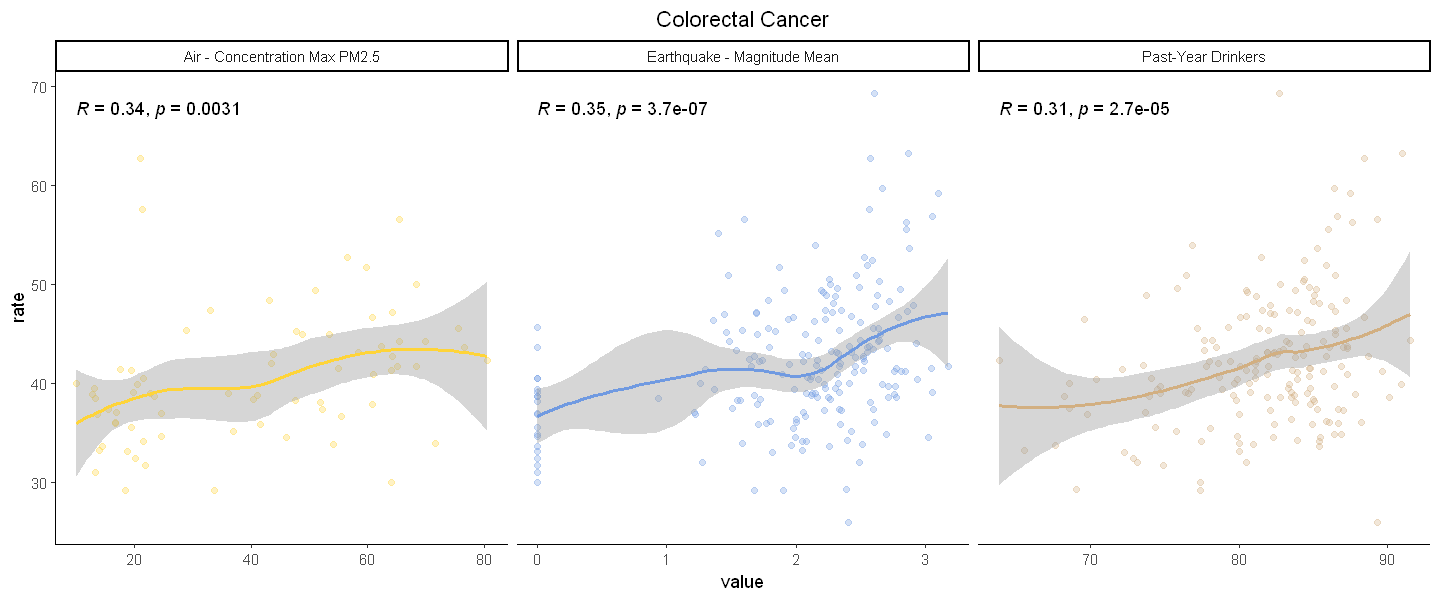

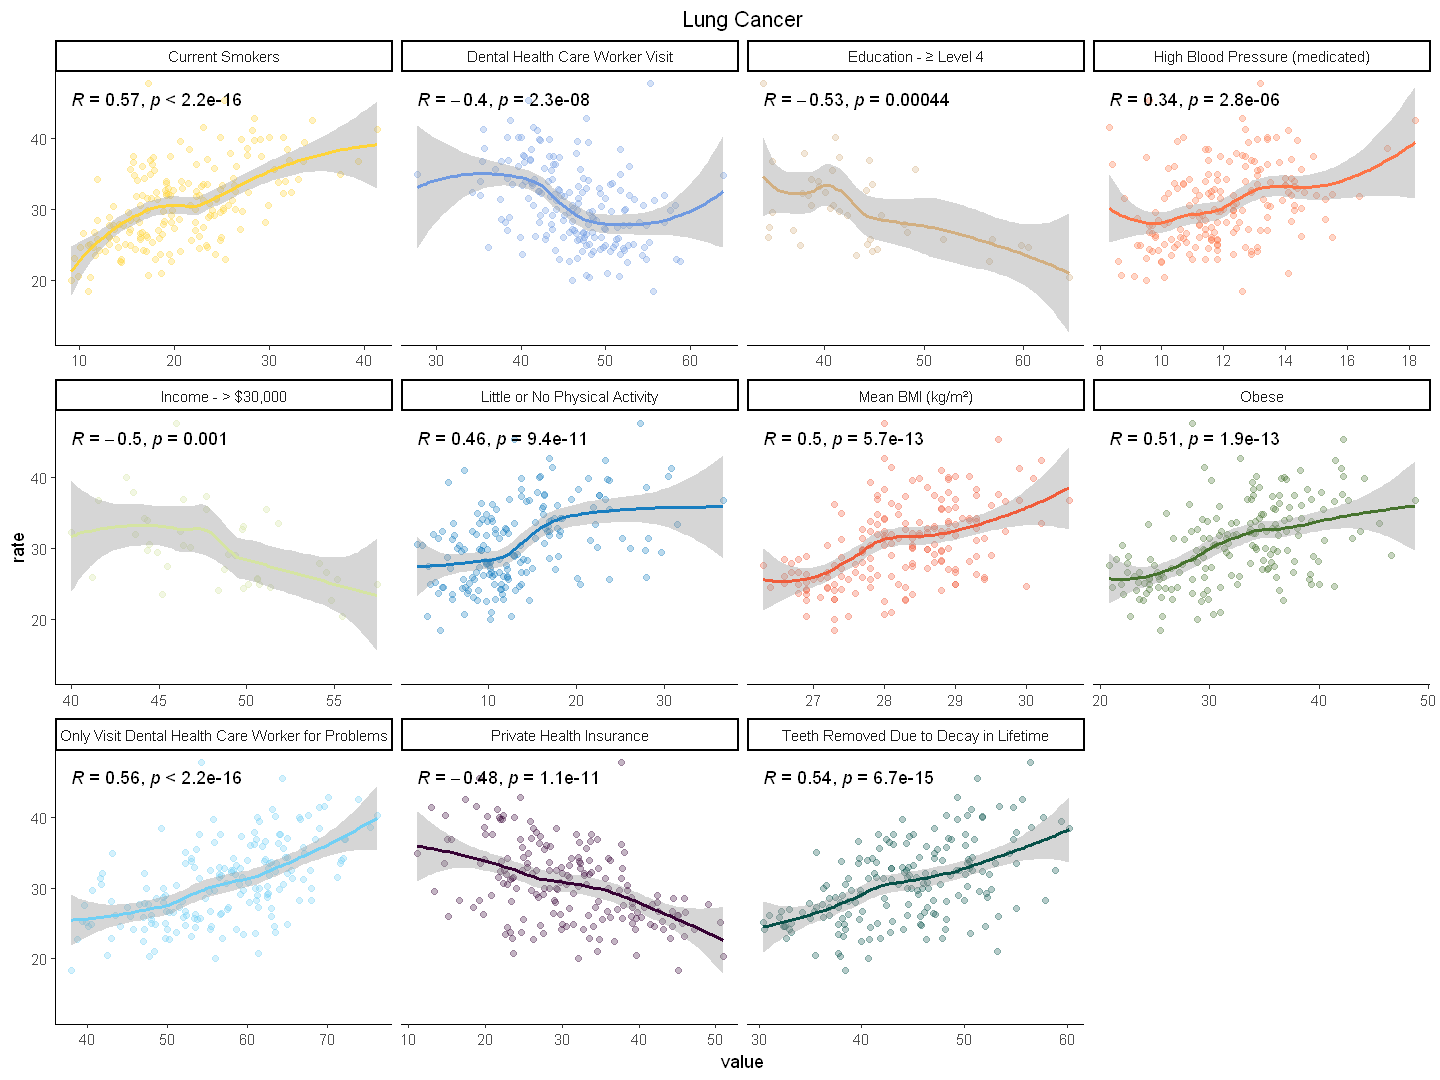

In [5]:
## Colorectal result visualization

ca = "Colorectal"
sig.table <- do.call(rbind,sig.tables)

corplot <- function(ca){
  load('data/clean/incidence_rf.Rdata')
  rfs <- sig.table %>% 
    filter(Cancer == ca) %>%
    mutate(group = case_when(Group == "Temperature" ~"tmp",
                             TRUE ~Group),
           group = tolower(group))
  
  lapply(1:nrow(rfs),function(i){
    group = rfs$group[i]
    feature = rfs$feature[i]
    df = incidence_rf[[ca]][[1]][[group]][,c("year",'DHB','incidence_rate',feature)] 
    colnames(df) = c("Year","DHB","rate",'value')
    df %>% mutate(RFs = rfs$`Risk Factors`[i], 
                  Category = rfs$Category[i], 
                  Group = rfs$Group[i], 
                  gg_group = paste(Group,'-',RFs),
                  gg_group = str_replace(gg_group,"NZHS - ",'')) %>%
      filter(!is.na(value))
  }) %>% do.call(rbind,.) %>%
    ggplot(.,aes(x = value, y =rate)) +
    geom_point(aes(color = gg_group),alpha = 0.3) +
    scale_color_manual(values = cols)+
    geom_smooth(aes(color = gg_group))+
    ggpubr::stat_cor( 
      label.x.npc = "left",
      label.y.npc = 'top') +
    facet_wrap(~gg_group,scales = 'free_x')+
    theme_classic()+
    ggtitle(paste(ca,"Cancer"))+
    theme(legend.position = 'none',
          plot.title = element_text(hjust = 0.5))

}

options(repr.plot.width=12, repr.plot.height=5)
corplot("Colorectal")

options(repr.plot.width=12, repr.plot.height=9)
corplot("Lung")